# Lab 05   ZIMIN MENG 22665473

# Import Data

In [364]:
#import the packages
import tensorflow as tf
from tensorflow import keras

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

import os
import pickle


In [365]:

pathname = '.'

In [366]:
# function for loading the data_batch_file
def load_pickle_file(filename, path='.'):

    with open(os.path.join(path,filename), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict  


def load_training(filename_prefix, N_batches, path='.', height=32, width=32, Nchannels=3):

    batch_no = range(1,N_batches+1)  # the batch numbers start at 1
    # Read in the data_batch_ files
    batches = [load_pickle_file(filename_prefix+str(b), path=path) for b in batch_no]

    batch_sizes = [len(batches[i][b'labels']) for i in range(N_batches)]
    train_set_size = np.sum(batch_sizes)
    
    X_train = np.zeros((train_set_size, width, height, Nchannels), dtype='float32')
    y_train = np.zeros(train_set_size).astype('uint8')
    loc = 0
    for i in range(N_batches):
        X_train[loc:(loc+batch_sizes[i]),:,:,:] = np.rollaxis(
            np.reshape(batches[i][b'data'], (-1,Nchannels,height,width)), 1, 4) / 255.0
        y_train[loc:(loc+batch_sizes[i])] = batches[i][b'labels']
        loc += batch_sizes[i]
    return X_train, y_train


def load_testing(filename, path='.', height=32, width=32, Nchannels=3):

    # now read test_batch and construct the test set
    test_dict = load_pickle_file(filename, path=path)
    
    X_test = np.rollaxis(np.reshape(test_dict[b'data'], (-1,Nchannels,height,width)), 1, 4) / 255.0
    X_test = X_test.astype('float32')
    y_test = np.array(test_dict[b'labels'], dtype='uint8')
    return X_test, y_test

In [367]:
# According to the download site, the training set is split into five batches stored in 5 files,
# each colour image has dimension equal to 32 x 32 x 3, and there are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

N_batches = 5  
train_filename_prefix = 'data_batch_'
test_filename = 'test_batch'

X_train, y_train = load_training(train_filename_prefix, N_batches, path=pathname)
X_test, y_test = load_testing(test_filename, path=pathname)

train_set_size = X_train.shape[0]
test_set_size = X_test.shape[0]
print('Number of training instances:', train_set_size)
print('Number of test instances:    ', test_set_size)

Number of training instances: 50000
Number of test instances:     10000


In [368]:
#Splitting validation set
(X_train, x_valid) = X_train[5000:], X_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

In [369]:
# X_train, y_train, X_test, and y_test are all numpy arrays
print('X_train.shape =', X_train.shape, 'data type:', X_train.dtype)
print('y_train.shape =', y_train.shape, 'data type:', y_train.dtype)
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)

X_train.shape = (45000, 32, 32, 3) data type: float32
y_train.shape = (45000,) data type: uint8
X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000,) data type: uint8


In [370]:
#Data using for CNN
X_train_2, y_train_2 = load_training(train_filename_prefix, N_batches, path=pathname)
X_test_2, y_test_2 = load_testing(test_filename, path=pathname)

(X_train_2, x_valid_2) = X_train_2[5000:], X_train_2[:5000]
(y_train_2, y_valid_2) = y_train_2[5000:], y_train_2[:5000]


# MLP Model

Initial model has 2 hidden layers and the first hidden layer has 300 neurons and the second hidden layer has 100 neurons, both two hidden layers are using ReLU activation function. Also the input layer has 32x32 input neurons and the output layer has 10 output neurons and using softmax activation function since the classes are exclusive.
For the model , the different settings we are using are shown as below:
- connection weight initialization =  'He_normal' and 'He_uniform'
- learning rate scheduling = Power scheduling('keras.optimizers.SGD(lr=0.01, decay=1e-4)') and Exponential scheduling(shown in model)
- early stopping = [monitor = 'acc', mode = 'max' ] and [monitor = 'val_loss', mode = 'auto']


# Result of experiments

The result for the experiment shows when using 'He_normal', 'Power Scheduling(lr=0.01, decay=1e-4' and early stopping 'acc' and 'max':
- loss: 1.1357 - accuracy: 0.6020 - val_loss: 1.3681 - val_accuracy: 0.5318
- loss: 1.3778 - accuracy: 0.5172 on training set 

The result for the experiment shows when using 'He_uniform', 'Exponential Scheduling(0.01 * 0.1**(epoch / 20)' and early stopping with (patience =10)'val_loss' and 'auto' :
- loss: 1.1226 - accuracy: 0.6079 - val_loss: 1.3543 - val_accuracy: 0.5248
- loss: 1.3449 - accuracy: 0.5251
 
From the result, we could see there is no big differece for the result for two experiments, but for the second experiment, the overall accuracy(52.51%) is little bit higher than the first experiment (51.72%).

Therefore, the second model is used to train and predict the class.

In [371]:
#Building Sequential model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32,3]), 
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu",kernel_initializer="he_uniform",use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu",kernel_initializer="he_uniform", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 3072)              12288     
_________________________________________________________________
dense_66 (Dense)             (None, 300)               921600    
_________________________________________________________________
batch_normalization_17 (Batc (None, 300)               1200      
_________________________________________________________________
dense_67 (Dense)             (None, 100)               30000     
_________________________________________________________________
batch_normalization_18 (Batc (None, 100)               400       
_________________________________________________________________
dense_68 (Dense)             (None, 10)              

In [372]:
#Compile the model
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer= 'sgd',
              metrics=["accuracy"])

In [373]:
import keras
from keras.callbacks import ModelCheckpoint


def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=10, mode = 'auto', restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath='MLP.weights.best.hdf5', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data = (x_valid, y_valid),
                    callbacks=[early_stopping_cb,lr_scheduler,checkpoint],
                   verbose=2, shuffle=True)


Train on 45000 samples, validate on 5000 samples
Epoch 1/10
 - 7s - loss: 1.7456 - accuracy: 0.3852 - val_loss: 1.5613 - val_accuracy: 0.4514

Epoch 00001: val_loss improved from inf to 1.56130, saving model to MLP.weights.best.hdf5
Epoch 2/10
 - 8s - loss: 1.5117 - accuracy: 0.4650 - val_loss: 1.4844 - val_accuracy: 0.4802

Epoch 00002: val_loss improved from 1.56130 to 1.48436, saving model to MLP.weights.best.hdf5
Epoch 3/10
 - 7s - loss: 1.4233 - accuracy: 0.4980 - val_loss: 1.4371 - val_accuracy: 0.4986

Epoch 00003: val_loss improved from 1.48436 to 1.43712, saving model to MLP.weights.best.hdf5
Epoch 4/10
 - 7s - loss: 1.3584 - accuracy: 0.5210 - val_loss: 1.4187 - val_accuracy: 0.5078

Epoch 00004: val_loss improved from 1.43712 to 1.41867, saving model to MLP.weights.best.hdf5
Epoch 5/10
 - 7s - loss: 1.3082 - accuracy: 0.5384 - val_loss: 1.3972 - val_accuracy: 0.5088

Epoch 00005: val_loss improved from 1.41867 to 1.39722, saving model to MLP.weights.best.hdf5
Epoch 6/10
 - 7

In [374]:
scores = model.evaluate(X_test, y_test, verbose =1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

#Predict
y_pred = model.predict(X_test)

10000/10000 [==============================] - 1s 60us/step
Test loss: 1.3430975616455079
Test accuracy: 0.5250999927520752


In [375]:
#Check the shape and use one hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_pred.shape
y_test.shape

(10000, 10)

# Result and Visulization

The classificaition report provides the precision , recall, f1_score for each class. From the result we can see the overall accuracy for MLP model is around 0.53 and for class'9' which is 'truck', the MLP has highest precison which is 0.63.
And the confusion matrix lists the prediction and the real class in the test set. Graphsshows the confusion matrix of the model, we could clearly see how many classes are correctly predict and how many of them are wrongly predicted. Additionally, it's also clearly shows the true label and the preidicted label thus we could easily compare the result and seeing for example which class is most easily being wrongly classified to another class. I.e, 180 'dog' are wrongly predicted as 'cat' which aslo matches with our intuitive in life. 

In [376]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    #Create a heatmap from a numpy array and two lists of labels.
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    #A function to annotate a heatmap.
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

In [1]:
from sklearn.metrics import confusion_matrix
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


# Convert predictions classes to one hot vectors 
Y_pred_classes = y_pred.argmax(axis=1)
# Convert validation observations to one hot vectors
Y_true = y_test.argmax(axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = y_pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = X_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(10,10))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

NameError: name 'y_pred' is not defined

In [378]:
y_pred1 = y_pred.argmax(axis=1)
y_pred_1 = keras.utils.to_categorical(y_pred1, 10)
y_pred_1.shape

(10000, 10)

In [379]:
##Report accuracy and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.60      0.59      0.60      1000
           1       0.64      0.60      0.62      1000
           2       0.43      0.39      0.41      1000
           3       0.35      0.30      0.33      1000
           4       0.43      0.46      0.44      1000
           5       0.45      0.40      0.42      1000
           6       0.51      0.67      0.58      1000
           7       0.60      0.58      0.59      1000
           8       0.67      0.66      0.66      1000
           9       0.56      0.60      0.58      1000

   micro avg       0.53      0.53      0.53     10000
   macro avg       0.52      0.53      0.52     10000
weighted avg       0.52      0.53      0.52     10000
 samples avg       0.53      0.53      0.53     10000



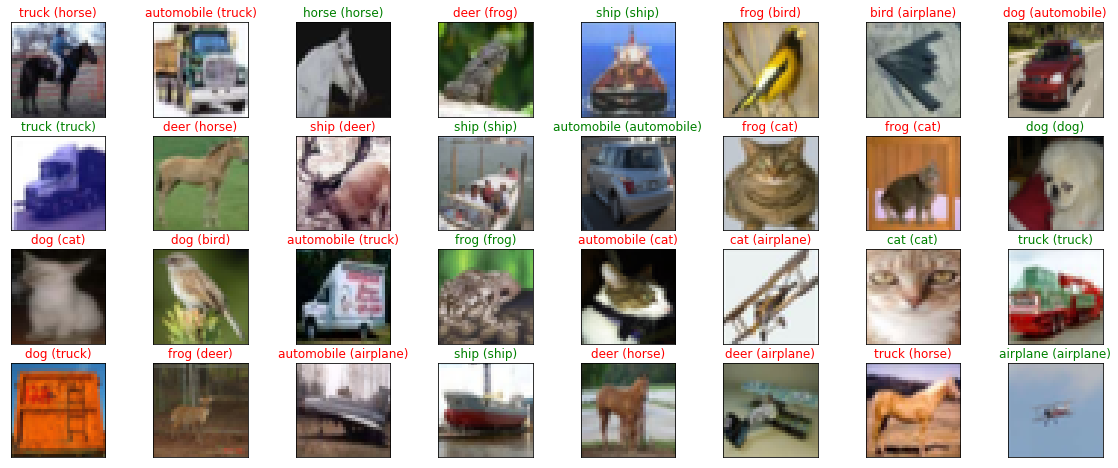

In [380]:
#Visulization
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(class_names[pred_idx], class_names[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

# CNN Model

This CNN model contains 2 convolution layers and 2 maxpooling layers associates with each convolution layer. 

The first designed CNN model has 2 convolution layers, the first one has 16 filters with size 2x2 and the second layer has 32 filters with size 2x2, and the activation function using ReLU function. After that we have a pooling layer with pool size = 2x2 and a dropout rate of 25%. And lastly is two fully connected layers.And we got result as following:
- loss: 1.0741 - accuracy: 0.6318 - val_loss: 0.9644 - val_accuracy: 0.6700
- Test accuracy: 0.6624 
The accuracy is 66.24% which is better than the MLP model but still not ideal.

Then for the second experiment, we use kernel size of 3x3 and changing number of kernels to 64 and 128 for each convolution layers respectively. Then changing drop rate from 25% to 30% but keep using 50% for the output layer. Activation function using ReLU function. This time the result is much better than before :
- loss: 0.7474 - accuracy: 0.7420 - val_loss: 0.8143 - val_accuracy: 0.7578
- Test accuracvy: 0.7466
Since there is a significant improve for the accuracy in second experiment, so I'll use the setting's in 2nd experiment to train the model.


In [403]:
#Data using for CNN
X_train_2, y_train_2 = load_training(train_filename_prefix, N_batches, path=pathname)
X_test_2, y_test_2 = load_testing(test_filename, path=pathname)


In [404]:
from keras.utils import np_utils
num_classes = len(np.unique(y_train))
y_train_2 = keras.utils.to_categorical(y_train_2, 10)
y_test_2 = keras.utils.to_categorical(y_test_2, 10)
 

(X_train_2, x_valid_2) = X_train_2[5000:], X_train_2[:5000]
(y_train_2, y_valid_2) = y_train_2[5000:], y_train_2[:5000]
 
print('x_train shape:', X_train_2.shape)
 
print(X_train_2.shape[0], 'train examples')
print(x_valid_2.shape[0], 'valid examples')
print(X_test_2.shape[0], 'test examples')

x_train shape: (45000, 32, 32, 3)
45000 train examples
5000 valid examples
10000 test examples


In [405]:
y_train_2.shape

(45000, 10)

In [406]:
#Building CNN Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
 
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=2, padding='same', input_shape=(32,32,3)))
cnn_model.add(MaxPooling2D(pool_size=2))


cnn_model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.3))


cnn_model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.3))

cnn_model.add(Flatten())
cnn_model.add(Dense(500, activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(10, activation='softmax'))

cnn_model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 4, 4, 128)       

In [407]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
cnn_model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

In [409]:
answer = input('Retraining the CNN model (y/n)?')
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='Zimin_Meng_CNN_final.h5', verbose=1, save_best_only=True)
if answer =='y':
    cnn_model.fit(X_train_2, y_train_2, 
                     batch_size=32, 
                     epochs=30,
                     validation_data = (x_valid_2, y_valid_2), 
                     callbacks=[checkpoint],
                     verbose=2, shuffle=True)
    tf.keras.models.save_model(cnn_model,pathname)
                
else:
    cnn_model = keras.models.load_model("Zimin_Meng_CNN_final.h5")

Retraining the CNN model (y/n)?n


In [418]:
#Make prediction
y_pred2 = cnn_model.predict(X_test_2)

In [416]:
# Convert predictions classes to one hot vectors 
y_temp = y_pred2.argmax(axis=1)
y_pred_2 = keras.utils.to_categorical(y_temp, 10)
y_pred_2.shape

(10000, 10)

Graphs below shows the confusion matrix of the model, we could clearly see how many classes are correctly predict and how many of them are wrongly predicted. Additionally, it's also clearly shows the true label and the preidicted label thus we could easily compare the result and seeing for example which class is most easily being wrongly classified to another class. I.e, 252 'cat' are wrongly predicted as 'dog' which aslo matches with our intuitive. 

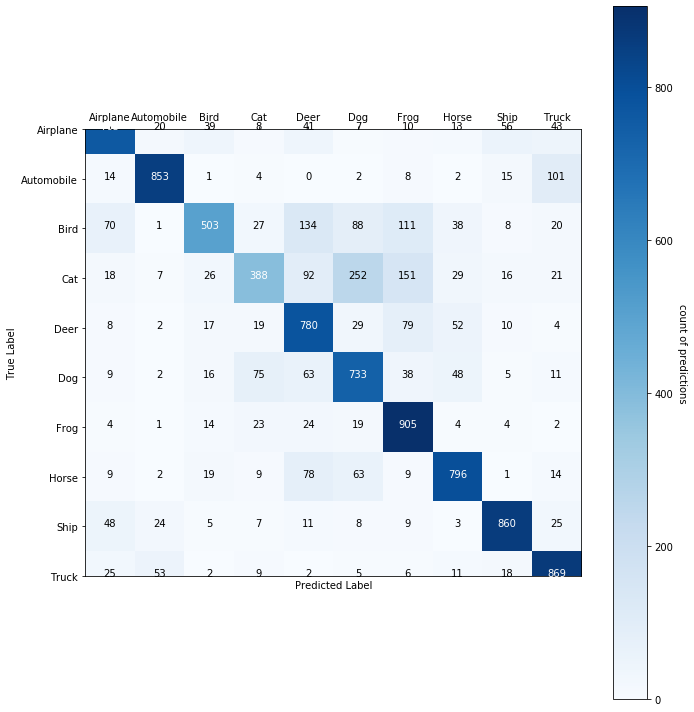

In [412]:
#Confusion Matrix Visulization

Y_pred_classes_2 = y_pred2.argmax(axis=1)
# Convert validation observations to one hot vectors
Y_true_2 = y_test_2.argmax(axis=1)
# Errors are difference between predicted labels and true labels
errors_2 = (Y_pred_classes_2 - Y_true_2 != 0)

Y_pred_classes_errors_2 = Y_pred_classes_2[errors_2]
Y_pred_errors_2 = y_pred_2[errors_2]
Y_true_errors_2 = Y_true_2[errors_2]
X_test_errors_2 = X_test_2[errors_2]

conf_matr2 = confusion_matrix(Y_true_2, Y_pred_classes_2) 
thresh2 = conf_matr2.max() / 2.

fig, ax = plt.subplots(figsize=(10,10))
im, cbar = heatmap(conf_matr2, labels, labels, ax=ax,
                   cmap=plt.cm.Purples, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=conf_matr2, threshold=thresh2)

fig.tight_layout()
plt.show()

Belowing is the classification report, in the report we could see the overall accuracy for the CNN model is around 75% and the precison for each class is also shown. In this model, class 1 gets a highest F1-score of 0.87 which means CNN works well in this class and have 87% probabilty to correct predict the instances in class1.

In [413]:
#Classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(y_test_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1000
           1       0.88      0.85      0.87      1000
           2       0.78      0.50      0.61      1000
           3       0.68      0.39      0.49      1000
           4       0.64      0.78      0.70      1000
           5       0.61      0.73      0.66      1000
           6       0.68      0.91      0.78      1000
           7       0.80      0.80      0.80      1000
           8       0.87      0.86      0.86      1000
           9       0.78      0.87      0.82      1000

   micro avg       0.74      0.74      0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000
 samples avg       0.74      0.74      0.74     10000



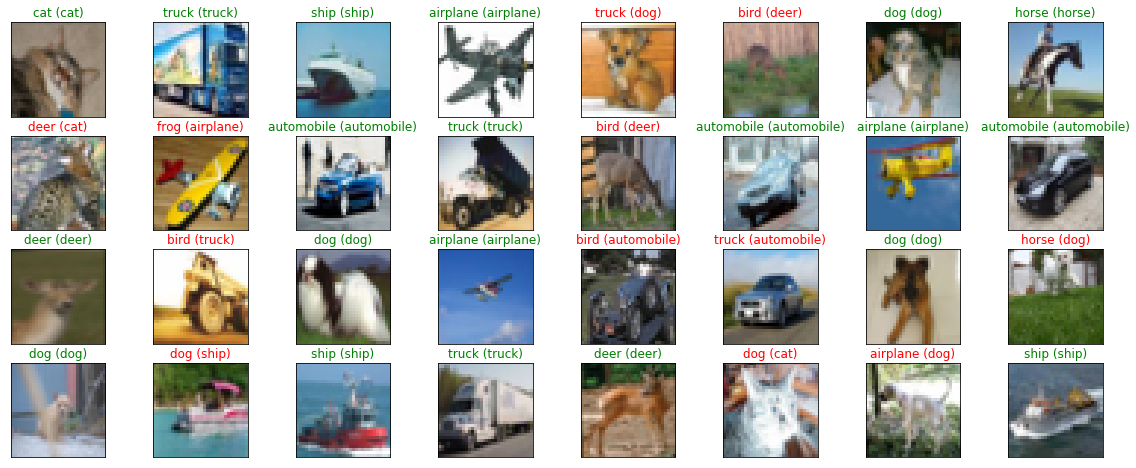

In [414]:
#Visulization of some classification images
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(class_names[pred_idx], class_names[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [393]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'Zimin_Meng_CNN_final.h5'

# Compare the result of MLP and CNN models

The overall accuracy for MLP is around 53% and 75% for CNN model. For most classes, the CNN model performs satisfied and performs extraodinary well for severl classes(i.e.'ship', 'airplane') since the accuracy is over 85%. Generally, CNN model performs better no matter for the whole model or individual class.
It's being noticed that both two models performs better than the model's average accuracy on class[0] and class [8] which is 'airplane' and 'ship'.  This may because there is no other similar class in the dataset, for instance, 'truck' and 'automobile' are sometimes similar and may increase the error.

The potential reasons for CNN to performs better maybe because of its complexitiy in structure, as well as the epochs. MLP is restricted to 10 epochs but CNN is set to have 30 epochs. Since we also try to use 10 epochs for CNN and the result(around 65% accuracy) is worse than the current 75% accuracy model. It can be seen that number of epochs do have significant influence on the model's performace.